In [1]:
from collections import Counter
import os
from glob import glob
import re

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns


sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [2]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_62881/661853690.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


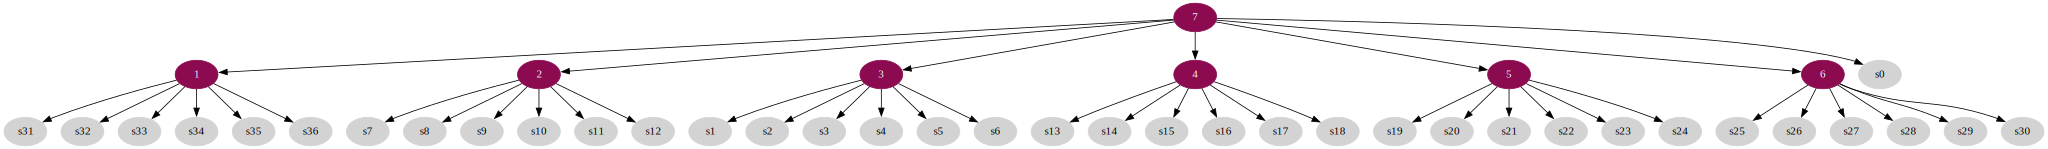

In [3]:
# Plot an example tree
Source.from_file('../../../mt-SCITE/mt-SCITE_output/Simulation/trees/0_cells/0_cells_0_pos_map0.gv')


## Clone map

In [4]:
data = pd.read_csv('../../data/simulated_clone_key/YFV2001_clone_key', sep = '\t')
data.head()

clones_map_raw = data.copy()

In [5]:
clones_map_raw.clone.value_counts()

1       6
2       6
3       6
4       6
5       6
6       6
bulk    1
Name: clone, dtype: int64

In [6]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [7]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

1       6
2       6
3       6
4       6
5       6
6       6
bulk    1
Name: clone, dtype: int64

## Load tree and pmat data

In [8]:
scite_input_path = '../../../mt-SCITE/mt-SCITE_output/Simulation/stdout/'
scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))
#scite_stdout_filenames


# Get log likelihood scores
experiments = []
lhood = []
n_trees = []
for filename in sorted(scite_stdout_filenames, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    name = os.path.basename(filename).split('-')[0].rsplit('.', 2)[0]
    experiments.append(name)
    #experiments = [float(x) for x in experiments]
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)
            lhood = [float(x) for x in lhood]
        if 'opt tree' in line:
            n = line.split(' opt')[0].lstrip()
            n_trees.append(n)
            n_trees = [int(x) for x in n_trees]

In [9]:
#experiments

In [10]:
pmat_input_path = '../../data/simulated_matrix_output/'
pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))
#pmats

# Get n mutations
n_mut = []
for filename in sorted(pmats, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    print(filename)
    file = open(filename, "r")
    n = len(file.readlines())
    n_mut.append(n)

../../data/simulated_matrix_output/0_cells_0_pos.csv
../../data/simulated_matrix_output/1_cells_1_pos.csv
../../data/simulated_matrix_output/1_cells_2_pos.csv
../../data/simulated_matrix_output/1_cells_3_pos.csv
../../data/simulated_matrix_output/1_cells_4_pos.csv
../../data/simulated_matrix_output/1_cells_5_pos.csv
../../data/simulated_matrix_output/1_cells_6_pos.csv
../../data/simulated_matrix_output/1_cells_7_pos.csv
../../data/simulated_matrix_output/1_cells_8_pos.csv
../../data/simulated_matrix_output/1_cells_9_pos.csv
../../data/simulated_matrix_output/1_cells_10_pos.csv
../../data/simulated_matrix_output/1_cells_11_pos.csv
../../data/simulated_matrix_output/1_cells_12_pos.csv
../../data/simulated_matrix_output/2_cells_1_pos.csv
../../data/simulated_matrix_output/2_cells_2_pos.csv
../../data/simulated_matrix_output/2_cells_3_pos.csv
../../data/simulated_matrix_output/2_cells_4_pos.csv
../../data/simulated_matrix_output/2_cells_5_pos.csv
../../data/simulated_matrix_output/2_cells_

In [11]:
# Create df
samples = 73
performance = pd.DataFrame(experiments)
performance['lhood'] = lhood
performance['n trees'] = n_trees
performance['n mutations'] = n_mut
performance['lhood'] = performance['lhood'].astype(float)
#tree_data['lhood_mut'] = tree_data['best log score for tree']/tree_data['n mutations']
performance['entries'] = performance['n mutations']*samples
performance['lhood_entries'] = performance['lhood']/performance['entries']
performance = performance.rename(columns={0: 'error_rate'})
performance = performance.set_index('error_rate')
performance

,lhood,n trees,n mutations,entries,lhood_entries
error_rate,,,,,
0_cells_0_pos,-3.811579,1,6,438,-0.008702
1_cells_1_pos,-3.920540,1,7,511,-0.007672
1_cells_2_pos,-4.029501,2,8,584,-0.006900
1_cells_3_pos,-4.138462,2,9,657,-0.006299
1_cells_4_pos,-4.247422,2,10,730,-0.005818
...,...,...,...,...,...
9_cells_8_pos,-119.083942,1,14,1022,-0.116520
9_cells_9_pos,-133.218334,2,15,1095,-0.121661
9_cells_10_pos,-149.549951,3,16,1168,-0.128039


In [12]:
#performance

In [13]:
error_rates = performance.index.tolist()
n_trees = performance['n trees'].tolist()
error_rates, n_trees

(['0_cells_0_pos',
  '1_cells_1_pos',
  '1_cells_2_pos',
  '1_cells_3_pos',
  '1_cells_4_pos',
  '1_cells_5_pos',
  '1_cells_6_pos',
  '1_cells_7_pos',
  '1_cells_8_pos',
  '1_cells_9_pos',
  '1_cells_10_pos',
  '1_cells_11_pos',
  '1_cells_12_pos',
  '2_cells_1_pos',
  '2_cells_2_pos',
  '2_cells_3_pos',
  '2_cells_4_pos',
  '2_cells_5_pos',
  '2_cells_6_pos',
  '2_cells_7_pos',
  '2_cells_8_pos',
  '2_cells_9_pos',
  '2_cells_10_pos',
  '2_cells_11_pos',
  '2_cells_12_pos',
  '3_cells_1_pos',
  '3_cells_2_pos',
  '3_cells_3_pos',
  '3_cells_4_pos',
  '3_cells_5_pos',
  '3_cells_6_pos',
  '3_cells_7_pos',
  '3_cells_8_pos',
  '3_cells_9_pos',
  '3_cells_10_pos',
  '3_cells_11_pos',
  '3_cells_12_pos',
  '4_cells_1_pos',
  '4_cells_2_pos',
  '4_cells_3_pos',
  '4_cells_4_pos',
  '4_cells_5_pos',
  '4_cells_6_pos',
  '4_cells_7_pos',
  '4_cells_8_pos',
  '4_cells_9_pos',
  '4_cells_10_pos',
  '4_cells_11_pos',
  '4_cells_12_pos',
  '5_cells_1_pos',
  '5_cells_2_pos',
  '5_cells_3_pos',


In [14]:
MAX_TREES_PER_ERROR_RATE = 20

all_trees = {}
for error_rate, n in zip(error_rates, n_trees):
    all_trees[error_rate] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        tree_filename = f'../../../mt-SCITE/mt-SCITE_output/Simulation/all_dot_files/{error_rate}_map{idx}.gv'
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        tree.remove_node('\\n')
        all_trees[error_rate].append(tree)

In [15]:
performance['tree_size'] = 0
for error_rate, trees in all_trees.items():
    n_nodes = [t.number_of_nodes() for t in trees]
    performance.loc[error_rate, 'tree_size'] = np.mean(n_nodes)

In [16]:
#performance

In [17]:
#t = all_trees['1'][0]

In [18]:
#clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
#clones_count

In [19]:
#root_node = str(get_root_node(t))
#print(root_node)

In [20]:
#clones_count

In [21]:
# drop root node
#clones_count = clones_count.drop(columns=['6'])
#clones_count

In [22]:
#p = purity(clones_count)
#p = p[[c for c in p.columns if c not in clones_map.keys()]]
#p

# Avg purity of nodes with >1 sample

In [23]:
performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    n_purities_100 = []
    for t in trees:
        #print(error_rate, get_root_node(t))
        root_node = str(get_root_node(t))
        #print(root_node)
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        p = p.drop(p.columns[[1]],axis = 1) # Drop root node
        print(p)
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        #print(avg_purities)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

        1    2    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0
        1    2    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0
        1    2    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0
        1    2    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0 

6     1.0  0.0  0.0  0.0  0.0  0.0
        1    2    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0
        1    2    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0
        1    2    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0
        1    2    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0 

6     1.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    3   13    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  1.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    3    4   13    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  1.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    3    4   13    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  1.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0


        1    2    7    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    7    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    7    3    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  1.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    7    3    4    5    6


        1        14    2    7    3    4    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1        14    2    7    3    4    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       13        14    2    7    3    4    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0 

6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1        15    2    7    3    4    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1        15    2    7    3    4   12    5    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1        15    2   14    3    4   12    5    6
bulk  0.0 

6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1        16    2    7    3    4    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1        16    2   14    3    4    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1        16    2   14    3    4    5   12    6
bulk  0.0 

        1        17    2   14    3    4    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       13        17    2   14    3    4    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       13        17    2    3   14    4    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0 

6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1        19    2   14    3    4   18   12    5   17    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1        19    2   14    3    4   18   12    5   17    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0
5     0.0  0.162162  0.0 

        9        12    2    3    4    7    5    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0
        9        12    2    3    4    7    5    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0
        9        12    2    3    4    7    5    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0


6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        9        14    2    3   13    4   10    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        9        14    2    3    4   13    7    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0 

6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        9        15    2    3   13    4    7    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        9        15    2    3    4   13    7    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0 

6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        9        16    2   15    3   13    4   10    5   12    6    8
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        9        16    2   15    3   13    4   10    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0 

        9        18    2   15    3   16    4   10    5   12    6         8
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.333333
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.333333
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.333333
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.000000
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.000000
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000
        1        18    2   15    3    4   16   10    5    6   12
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
5     0.0 

        9        19    2   15    3   16    4    7    5   18   17    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        9        19    2    3   15   16    4    7    5   18   17    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0
5     0.0  0.162162 

        1    2   10    3   11   13    8    4   12    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
2     0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2   10    3   11   13    8    4   12    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
2     0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1   10    2    3   11   13    8 

6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1   10    2   11   13    3    8    4   12    5   15    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1   10    2   11   13    3    8    4    5   12   15    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
5     0.0  0.0  0.0  0.0 

6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1   10    2   13    3    8    4   12    5   15    6   11         7
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.333333
1     0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000
2     0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000
3     0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.000000
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.000000
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.5  0.333333
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.333333
        1   10    2   11   13    3    8    4   12    5    6   15
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0 

6     0.333333  
        1        18   10    2    3   11   13    8    4   12    5   15    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1        18   10    2   11   13    3    8    4   12    5   15    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.

6     0.5  0.333333  
        1    2    3    4    7    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    8    3    4    7    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    8    3    7    4    5    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.0  0.0  0.0  0.

6     0.0  0.0  
       12   13        16   15    2    8    3   11    7    4    9    5   10  \
bulk  0.0  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.162162  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.162162  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
4     0.0  0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
5     0.0  0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6     1.0  1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       14    6  
bulk  0.0  0.0  
1     0.0  0.0  
2     0.0  0.0  
3     0.0  0.0  
4     0.0  0.0  
5     1.0  1.0  
6     0.0  0.0  
       12   13        17   15    2    8    3   14    7   11   16    4    9  \
bulk  0.0  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.162162  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  

       12   13        19   15    2    8    3   11   16    4   10    5    7  \
bulk  0.0  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.162162  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.162162  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
4     0.0  0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
5     0.0  0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6     1.0  1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       17   18   14    6  
bulk  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  
4     1.0  1.0  0.0  0.0  
5     0.0  0.0  1.0  1.0  
6     0.0  0.0  0.0  0.0  
        7         8    2    3    4    5    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  0.0  0.0  0.0
2     0.0  0.162162  1.0

6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        8        13    7    2   10   11    3    4    9    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        9        13    7    2   10   11    3    4    8    5   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162 

6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        9        14    7    2   11    3   13    4    8    5   10   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        7        14   10    2   11    3   13    4    8    5    9   12    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0 

6     0.0  0.0  
        7        16   14    2   15    3   11    4    8    5    9   10   12  \
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.162162  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.162162  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        6   13  
bulk  0.0  0.0  
1     0.0  0.0  
2     0.0  0.0  
3     0.0  0.0  
4     0.0  0.0  
5     1.0  1.0  
6     0.0  0.0  
        7        16   14    2   11    3   15    4    8    5    9   10   12  \
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.162162  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  

6     0.0  0.0  
        8        17   14    2   11   15    3   13    4   16    9    5   10  \
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.162162  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.162162  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        7    6   12  
bulk  0.0  0.0  0.0  
1     0.0  0.0  0.0  
2     0.0  0.0  0.0  
3     0.0  0.0  0.0  
4     0.0  0.0  0.0  
5     1.0  1.0  1.0  
6     0.0  0.0  0.0  
        9        17   14    2   11   15    3   13    4   16    8    5   10  \
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.162162  0.0  

6     0.166667  0.000000  0.000000  0.000000  0.000000  1.0  0.4  0.0  
       15    3        19   16    4        18         7         8    5  \
bulk  0.0  0.0  0.027027  0.0  0.0  0.000000  0.000000  0.333333  0.0   
1     1.0  1.0  0.162162  0.0  0.0  0.000000  0.000000  0.000000  0.0   
2     0.0  0.0  0.162162  0.0  0.0  0.333333  0.333333  0.000000  0.0   
3     0.0  0.0  0.162162  1.0  1.0  0.000000  0.000000  0.000000  0.0   
4     0.0  0.0  0.162162  0.0  0.0  0.000000  0.000000  0.666667  1.0   
5     0.0  0.0  0.162162  0.0  0.0  0.333333  0.333333  0.000000  0.0   
6     0.0  0.0  0.162162  0.0  0.0  0.333333  0.333333  0.000000  0.0   

             9        17        13        10        14    1   12    6  
bulk  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  
1     0.166667  0.333333  0.000000  0.000000  0.000000  0.0  0.0  0.0  
2     0.166667  0.333333  0.333333  0.285714  0.333333  0.0  0.2  0.0  
3     0.166667  0.333333  0.333333  0.142857  0.000000 

6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    7    9    3    4    5    8    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        7        11    2    9    3    4    5    8    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    9    3    7    4    5    8    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0 

6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        7        12    2    9    3   11    4    5    8    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    9    3   11    4    5    7    8    6
bulk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0
6     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        1    2    9    3   11 

       13        16    2    9    3   11    4    7   14   12    5   15    8  \
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0   
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        6    10  
bulk  0.0  0.25  
1     0.0  0.00  
2     0.0  0.00  
3     0.0  0.25  
4     0.0  0.00  
5     1.0  0.25  
6     0.0  0.25  
       13        16   15    2    9    3   14    7    4   11   12    5    8  \
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.162162  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

        7        17   15    2   16   12    9    3   13   11    4   14    5  \
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2     0.0  0.162162  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0   
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        8    6  
bulk  0.0  0.0  
1     0.0  0.0  
2     0.0  0.0  
3     0.0  0.0  
4     0.0  0.0  
5     1.0  1.0  
6     0.0  0.0  
        7        17   15    2   16    9    3   13   11    4   14   12    5  \
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
2    

6     0.0  0.0  0.0  0.333333  0.25  
       16        19   15    2    9    3   13   11    4    7   14   12    5  \
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.162162  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.162162  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       17    6    8        18    10  
bulk  0.0  0.0  0.0  0.333333  0.25  
1     0.0  0.0  0.0  0.000000  0.00  
2     0.0  0.0  0.0  0.000000  0.00  
3     0.0  0.0  0.0  0.333333  0.25  
4     0.0  0.0  0.0  0.000000  0.00  
5     1.0  1.0  1.0  0.000000  0.25  
6     0.0  0.0  0.0  0.333333  0.25  
        7        19   15    2   1

6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       10        12    2    9    8    3    7    4   11    5    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       10        12   11    2    8    3    7    4    9    5    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
5     0.0  0.162162  0.0 

6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       10        13    2    8   12    3    9    4    7    5   11    6
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.162162  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
4     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0
5     0.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6     1.0  0.162162  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       10        13    2    8    3    9    4   11    5    6   12    7
bulk  0.0  0.027027  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.162162  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.2  0.2
2     0.0  0.162162  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.2
3     0.0  0.162162  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.2  0.2
4     0.0  0.162162 

6     0.000000  0.00  0.333333  0.250  0.2  1.0  0.4  0.0  0.25  


# Clone coverage at full purity

In [24]:
performance['min_clone_coverage'] = np.nan
performance['avg_clone_coverage'] = np.nan
for error_rate, trees in all_trees.items():
    t = trees[0]

    clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
    p = purity(clones_count)
    #print(p)
    #p = p.drop(p.columns[[1]],axis = 1) # Drop root node!!!
    is_pure = p.max(axis=0) == 1.0
    #print(is_pure)
    coverage_per_clone = clones_count.loc[:, is_pure].div(n_samples_per_clone, axis=0).max(axis=1)
    #print(error_rate, '\n', coverage_per_clone, '\n---')
    min_coverage = coverage_per_clone.min()
    avg_coverage = coverage_per_clone.drop('bulk').mean()
    performance.loc[error_rate, 'min_clone_coverage'] = min_coverage
    performance.loc[error_rate, 'avg_clone_coverage'] = avg_coverage

!! possible mutation in a leaf: not found 13
!! possible mutation in a leaf: not found 8


# Plots

In [25]:
# add n mutated cells
n_pos = []
for i in experiments:
    #print(i)
    i = i.split('_')
    #i = i.rpartition('pos')
    #print(i[2])
    #print(i[-5])
    n_pos.append(i[2])
print(n_pos)
    
performance['n_pos'] = n_pos

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


In [26]:
n_cells = []
for i in experiments:
    n_cells.append(i[0])
performance['n_cells'] = n_cells

In [27]:
#performance

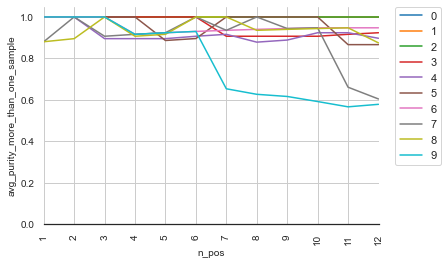

In [28]:
with plot_style(figsize=(4, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="n_pos", y="avg_purity_more_than_one_sample", hue = 'n_cells')
    plt.grid(axis='both')
    plt.ylim(0, 1.05)
    plt.xlim(1, 12)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

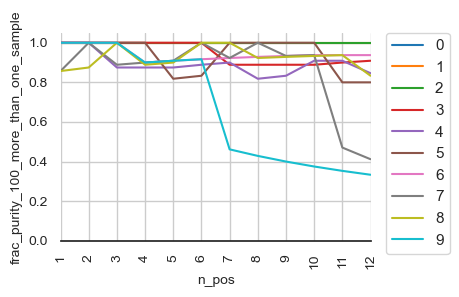

In [29]:
with plot_style(figsize=(4, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="n_pos", y="frac_purity_100_more_than_one_sample", hue = 'n_cells')
    plt.grid(axis='both')
    plt.ylim(0, 1.05)
    plt.xlim(1, 12)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

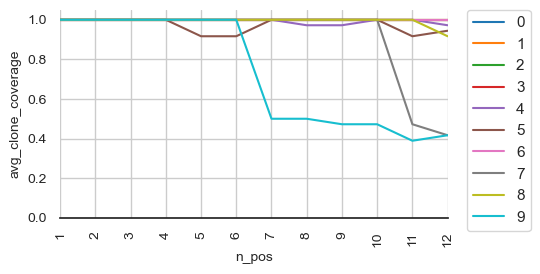

In [30]:
with plot_style(figsize=(5, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="n_pos", y="avg_clone_coverage", hue = 'n_cells')
    plt.grid(axis='both')
    plt.ylim(0, 1.05)
    plt.xlim(1, 12)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

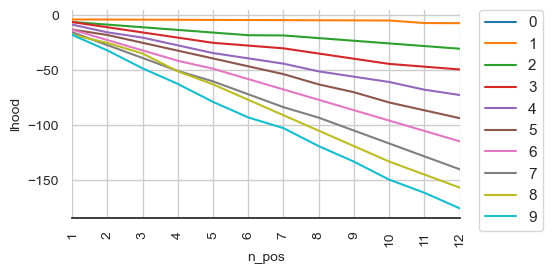

In [31]:
with plot_style(figsize=(5, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="n_pos", y="lhood", hue = 'n_cells')
    plt.grid(axis='both')
    #plt.ylim(0, 1.05)
    plt.xlim(1, 12)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

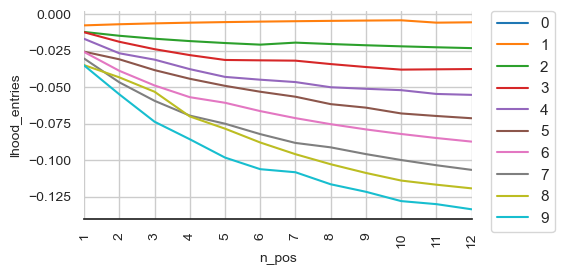

In [32]:
with plot_style(figsize=(5, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="n_pos", y="lhood_entries", hue = 'n_cells')
    plt.grid(axis='both')
    #plt.ylim(0, 1.05)
    plt.xlim(1, 12)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

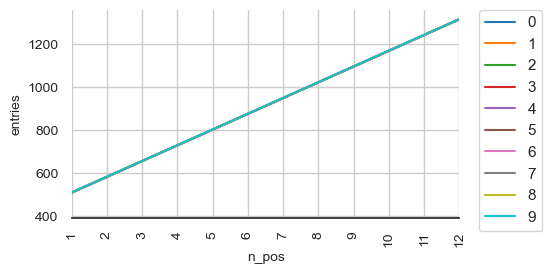

In [33]:
with plot_style(figsize=(5, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="n_pos", y="entries", hue = 'n_cells')
    plt.grid(axis='both')
    #plt.ylim(0, 1.05)
    plt.xlim(1, 12)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

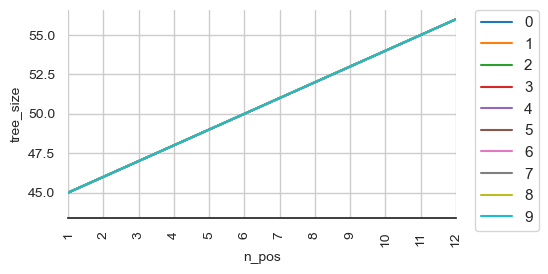

In [34]:
with plot_style(figsize=(5, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="n_pos", y="tree_size", hue = 'n_cells')
    plt.grid(axis='both')
    #plt.ylim(0, 1.05)
    plt.xlim(1, 12)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)